In [63]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import itertools
from time import time
from tqdm import tqdm
import seaborn as sns

%matplotlib inline

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
label = pd.read_csv('./challenge_output_data_training_file_nba_challenge.csv', sep=';')
train = pd.merge(train, label, on='ID')

### Feature Engineering

In [5]:
import feat_eng

In [6]:
train = feat_eng.add_tot_rebounds(train)
train = feat_eng.add_fg(train)

100%|██████████| 1440/1440 [00:21<00:00, 67.91it/s]


In [7]:
df_train, df_val = train_test_split(train, test_size=0.2, random_state=42)

### Rules

In [4]:
diff_goals = 8
temp = df_train[(df_train.score_1440 <= -1*diff_goals) | (df_train.score_1440 >= diff_goals)]
same_mt_f = df_train[((df_train.score_1440 <= -1*diff_goals) & (df_train.label == 0)) | ((df_train.score_1440 >= diff_goals) & (df_train.label == 1))]
print('Probability that the %d pt margin half-time leader (%.3f of full train set) is the full-time winner %.3f' % (diff_goals, len(temp)/len(df_train), len(same_mt_f)/len(temp)))

Probability that the 8 pt margin half-time leader (0.464 of full train set) is the full-time winner 0.854


In [6]:
df_train_2 = df_train[~df_train.ID.isin(temp.ID.values)]
diff_assists = 6
same_mt_f = df_train_2[((df_train_2.assist_1440 <= -1*diff_assists) & (df_train_2.label == 0)) 
                   | ((df_train_2.assist_1440 >= diff_assists) & (df_train_2.label == 1))]
temp2 = df_train_2[(df_train_2.assist_1440 <= -1*diff_assists) | (df_train_2.assist_1440 >= diff_assists)]
print('Probability that the %d assist margin half-time leader (%.3f of remaining train set) is the full-time winner %.3f' % (diff_assists, len(temp2)/len(df_train_2), len(same_mt_f)/len(temp2)))

Probability that the 6 assist margin half-time leader (0.138 of remaining train set) is the full-time winner 0.610


In [32]:
diff_goals = 1
temp = df_train_2[(df_train_2.score_1440 <= -1*diff_goals) | (df_train_2.score_1440 >= diff_goals)]
same_mt_f = df_train_2[((df_train_2.score_1440 <= -1*diff_goals) & (df_train_2.label == 0)) | ((df_train_2.score_1440 >= diff_goals) & (df_train_2.label == 1))]
print('Probability that the %d pt margin half-time leader (%.3f of remaining train set) is the full-time winner %.3f' % (diff_goals, len(temp)/len(df_train_2), len(same_mt_f)/len(temp)))

Probability that the 1 pt margin half-time leader (0.921 of remaining train set) is the full-time winner 0.617


In [11]:
def predict_from_rules(x): 
    # Score margin at HT
    diff_goals = 8
    if x.score_1440 <= -1*diff_goals:
        return 0.15
    if x.score_1440 >= diff_goals:
        return 0.85
    
    diff_goals = 6
    if x.score_1440 <= -1*diff_goals:
        return 0.28
    if x.score_1440 >= diff_goals:
        return 0.72
    
    diff_goals = 1
    if x.score_1440 <= -1*diff_goals:
        return 0.38
    if x.score_1440 >= diff_goals:
        return 0.62
    
    # Assist margin at HT
    diff_assists = 6
    if x.assist_1440 <= -1*diff_assists:
        return 0.39
    if x.assist_1440 >= diff_assists:
        return 0.61
    
    return 0.5

In [12]:
df_temp = df_val.copy()
df_temp['prediction'] = df_temp.apply(predict_from_rules, axis=1)

In [15]:
(df_temp['prediction'].apply(round) == df_temp['label']).mean()

0.7233704292527822

### Random Forest

#### Grid Search

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [26]:
y = df_train.label.values
X = df_train.drop(['ID', 'label'], axis=1)

In [46]:
scores = []
nb_iter = 25
for k in range(nb_iter):
    start = time()
    params = {"n_estimators" : np.random.choice([20, 50, 100, 200]),
              "max_depth": np.random.choice([2, 3, 5, None]),
              "max_features":np.random.choice(list(range(1,19, 2))+[None]),
              "min_samples_split": np.random.randint(2, 20),
              "min_samples_leaf": np.random.randint(1, 20),
              "bootstrap": True,
              "oob_score":True,
              "criterion": np.random.choice(["gini", "entropy"])}
    rf = RandomForestClassifier(**params)
    rf.fit(X, y)
    scores.append([rf.oob_score_, params, time()-start])

In [47]:
scores = sorted(scores, key=lambda x:x[0], reverse=True)
for i, score in enumerate(scores):
    print('Model #%d computed in %d sec :' % (i+1, score[2]))
    print('OOB score : %.3f with params %s' % (score[0], score[1]))

In [8]:
best_params = {'n_estimators': 200, 'max_depth': None, 'max_features': 15, 
               'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True, 
               'oob_score': True, 'criterion': 'entropy'}

#### Full training

In [12]:
y = train.label.values
X = train.drop(['ID', 'label'], axis=1)

In [13]:
rf = RandomForestClassifier(**best_params)
_ = rf.fit(X, y)
print(rf.oob_score_)

In [28]:
y_pred = rf.predict(X_val)
np.mean(y_pred == y_val)

0.7452305246422893

In [21]:
feat_names = X.columns[np.argsort(rf.feature_importances_)[::-1]]
feat = np.sort(rf.feature_importances_)[::-1]

In [36]:
all_features = set([k.split('_')[0] for k in feat_names])
feat_min_idx = sorted([min([i for i,k in enumerate(feat_names) if k.split('_')[0] == feat]) for feat in all_features])
feat_names2 = feat_names[feat_min_idx]
feat2 = feat[feat_min_idx]

In [57]:
def correct_label(x):
    x = x.replace('_','\n')
    x = x.replace("defensive", 'def')
    x = x.replace('offensive', 'off')
    return x.replace('total', '')

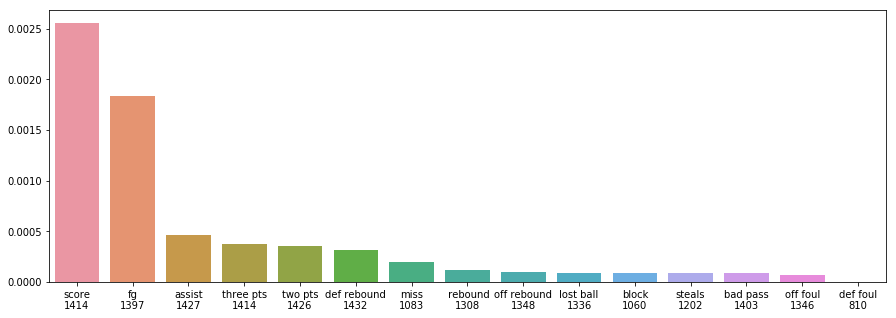

In [58]:
f, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=feat_names2, y=feat2, order=feat_names2)
_=ax.set_xticklabels([correct_label(k.get_text()) for k in ax.get_xticklabels()])

### Ensemble methods

In [13]:
from keras.models import load_model
my_model = load_model('./my_model_convlstm.h5')

#### Data preparation

In [78]:
def prepare_data(df, conf, test=False):
    """
    :param conf: score min to keep RF predictions
    """
    to_pred = df[(df['RF_prediction'] > 1-conf) & (df_temp['RF_prediction'] < conf)]
    ids = to_pred.ID.values
    # Add total rebound
    for k in range(1,1441):
        to_pred['total rebound_%d' % k] = to_pred['offensive rebound_%d' % k] + to_pred['defensive rebound_%d' % k]
    temp = to_pred
    if not test:
        cols_kept = ['ID', 'label', 'prediction', 'RF_prediction']
    else:
        cols_kept = ['ID', 'prediction', 'RF_prediction']
    cols_values = ['score', 'offensive rebound', 'defensive rebound',
           'offensive foul', 'defensive foul', 'assist', 'lost ball',
           'steals', 'bad pass', 'block', 'miss', 'total rebound']
    cols_sec = [k for k in temp.columns if any(x in k for x in cols_values)]
    df_id = pd.DataFrame()

    for sec in tqdm(range(1, 1441)):
        df_sec = temp[cols_kept + [k for k in cols_sec if k.split('_')[1] == str(sec)]]
        df_sec.columns = cols_kept + cols_values
        df_sec = df_sec.assign(time_step = sec)
        df_id = pd.concat([df_id, df_sec])
    df_id.ID = df_id.ID.astype("category")
    df_id.ID.cat.set_categories(ids, inplace=True)
    df_id = df_id.sort_values(["ID", 'time_step'])
    X_val = []
    for id_ in tqdm(ids):
        X_val.append(df_id[df_id.ID == id_][cols_values].values)
    X_val = np.array(X_val)
    print(X_val.shape)
    return X_val, to_pred

In [59]:
X_val, to_pred = prepare_data(df_temp, 0.58)

#### Prediction

In [67]:
y_pred = my_model.predict(X_val, batch_size=32)

In [60]:
to_pred['LSTM'] = y_pred[:,1]
lstm_pred = to_pred[['ID','LSTM']].set_index('ID').to_dict()['LSTM']

In [69]:
df_temp['LSTM'] = df_temp.apply(lambda x:lstm_pred.get(x.ID, x.RF_prediction), axis=1)

In [75]:
l = []
for i,j,k in itertools.permutations(np.arange(10), 3):
    df_temp['pred'] = (df_temp['prediction']*i + df_temp['RF_prediction']*k + df_temp['LSTM']*j)/(i+k+j)
    r = (df_temp['pred'].apply(round) == df_temp['label']).mean()
    l.append([(i,j,k), r])
sorted(l, key=lambda x:x[1], reverse=True)[:3]

[[(1, 8, 9), 0.75],
 [(1, 7, 9), 0.7496025437201908],
 [(1, 9, 6), 0.7496025437201908]]

### Test

#### RF

In [46]:
X_test = feat_eng.add_tot_rebounds(test)
X_test = feat_eng.add_fg(X_test, test=True)

100%|██████████| 1440/1440 [00:09<00:00, 150.36it/s]


In [49]:
X_test = X_test.drop(['ID'], axis=1)
test['label'] = rf.predict_proba(X_test)[:,1]
test['label'] = test['label'].apply(round)

#### Ensemble

In [61]:
X_test = test.drop(['ID'], axis=1)
test['RF_prediction'] = rf.predict_proba(X_test)[:,1]
test['prediction'] = test.apply(predict_from_rules, axis=1)
X_test, to_pred_test = prepare_data(test, 0.58, True)

In [62]:
y_ = my_model.predict(X_test, batch_size=32)
to_pred_test['LSTM'] = y_[:,1]
lstm_pred = to_pred_test[['ID','LSTM']].set_index('ID').to_dict()['LSTM']
test['LSTM'] = test.apply(lambda x:lstm_pred.get(x.ID, x.RF_prediction), axis=1)
i, j, k = 1, 8, 9
test['label'] = (test['prediction']*i + test['RF_prediction']*k + test['LSTM']*j)/(i+k+j)

In [86]:
test[['ID', 'label']].to_csv('pred_RF2.csv', index=False)